In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
%matplotlib inline

In [2]:
import numpy
numpy.version.version

'1.11.1'

In [3]:
class CameraCalibration():
    
    def __init__(self, imgs, hcount, vcount):
        self.mtx = None  # Camera Matrix
        self.dist = None  # Distortion Coefficients

        self.size = None  # Image size
        self.hcount = hcount  # Width of chessboard
        self.vcount = vcount  # Height of chessboard

        self.calibrated = False  # Whether the camera has been calibrated

        objpoints, imgpoints = self._get_all_points(imgs)
        self.mtx, self.dist = self._calibrate(objpoints, imgpoints)

    # Generate a matrix of x, y, z object points
    def _gridspace(self, ):
        # Initialise 2D array of zeros, needs to be float to stop OpenCV from complaining
        obj = np.zeros((self.hcount * self.vcount, 3)).astype(np.float32)
        # For x and y, fill with a grid of ascending values
        obj[:, :2] = np.mgrid[0:self.hcount, 0:self.vcount].T.reshape(-1, 2)
        return obj

    # Get the image points and the object points for a single image
    def _get_points(self, img):
        objp = self._gridspace() # Generate 3D object points for chessboard
        
        # Convert to grayscale, using RGB instead of BGR as mpimg uses a RGB format
        grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Save size of image for later use
        self.size = grey.shape[::-1]

        # Detect chessboard corners
        ret, corners = cv2.findChessboardCorners(grey, (self.hcount, self.vcount), None)
        
        # If OpenCV was able to find the chessboard, we return the corners along with 
        # the object points for calibration. Otherwise, we return None (when an error occurs)
        if ret:
            return corners, objp
        else:
            return None, None

    # Get the object and image points for all images.
    def _get_all_points(self, imgs):
        objpoints = []
        imgpoints = []
        for i, img in enumerate(imgs):
            imgp, objp = self._get_points(img)
            if imgp is None:
                # Warn if image is skipped
                print('[CameraCalibration] Image {} skipped during calibration as chessboard is not fully visible'.format(i))
            else:
                objpoints.append(objp)
                imgpoints.append(imgp)
            
        return objpoints, imgpoints

    # Get camera coefficients
    def _calibrate(self, objpoints, imgpoints):
        # Calculate the camera matrix and the distortion coefficients. This is what we need in order to undistort
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, self.size, None, None)
        return mtx, dist

    # Apply the distortion coefficients to an image
    def undistort(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)

In [4]:
# Class for perspective transforms
class PerspectiveTransformer():
    def __init__(self, src, dist):
        self.Mpersp = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)
        
    # Apply perspective transform
    def warp(self, img):
        return cv2.warpPerspective(img, self.Mpersp, (img.shape[1], img.shape[0]))
    
    # Reverse perspective transform
    def unwarp(self, img):
        return cv2.warpPerspective(img, self.Minv, (img.shape[1], img.shape[0]))

In [5]:
# Initialise the camera calibration, so it can be applied to future images
calib_imgs = [mpimg.imread(f) for f in sorted(glob.glob('./camera_cal/*.jpg'))]
calibration = CameraCalibration(calib_imgs, 9, 6)

#src = np.array([[585, 460], [203, 720], [1127, 720], [695, 460]]).astype(np.float32)
#dst = np.array([[320, 0], [320, 720], [960, 720], [960, 0]]).astype(np.float32)
src = np.array([[220,720], [1110, 720], [722, 470], [570, 470]]).astype(np.float32)
dst = np.array([[320,720], [920, 720], [920, 1], [320, 1]]).astype(np.float32)



# Create transformer object, this means that the transformer matrix only needs to be computed once
transform = PerspectiveTransformer(src, dst)

[CameraCalibration] Image 0 skipped during calibration as chessboard is not fully visible
[CameraCalibration] Image 14 skipped during calibration as chessboard is not fully visible
[CameraCalibration] Image 15 skipped during calibration as chessboard is not fully visible


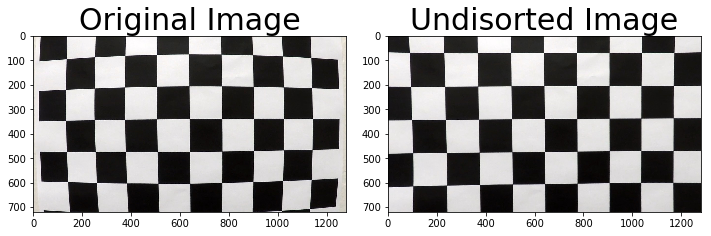

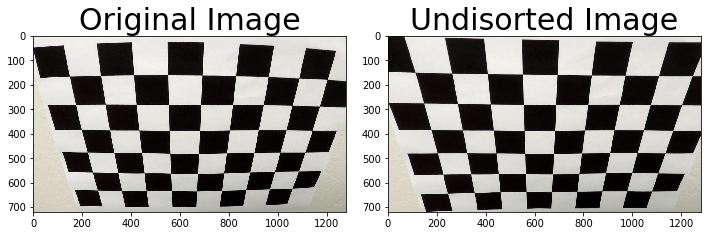

In [6]:
#test warp and undistort functions
for i in range(1,3):
    fname = 'camera_cal/calibration{}.jpg'.format(i)
    img = cv2.imread(fname)
    undist_test = calibration.undistort(img)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    plt.tight_layout()
    ax1.imshow(mpimg.imread(fname))
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(cv2.cvtColor(undist_test, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undisorted Image', fontsize=30)
    plt.savefig('output_images/undist_cal_image.jpg', bbox_inches='tight')

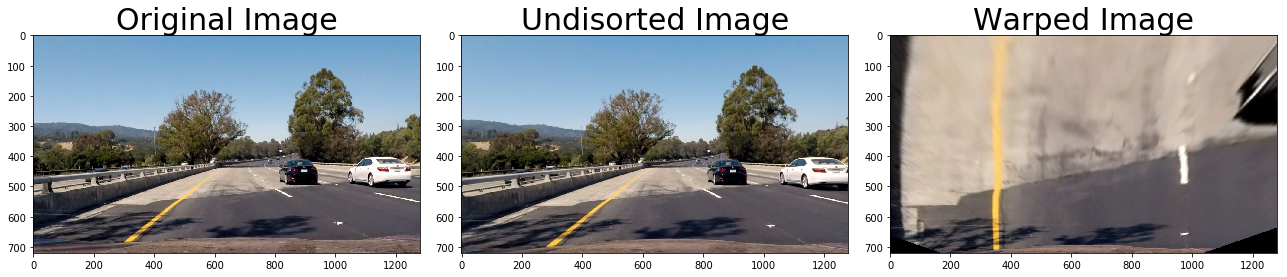

In [7]:
#test warp and undistort functions
for i in range(4,5):
    fname = 'test_images/test{}.jpg'.format(i)
    img = mpimg.imread(fname)
    undist_test = calibration.undistort(img)
    warp_test = transform.warp(undist_test)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(undist_test)
    ax2.set_title('Undisorted Image', fontsize=30)
    ax3.imshow(warp_test)
    ax3.set_title('Warped Image', fontsize=30)
    plt.savefig('output_images/warped.jpg', bbox_inches='tight')

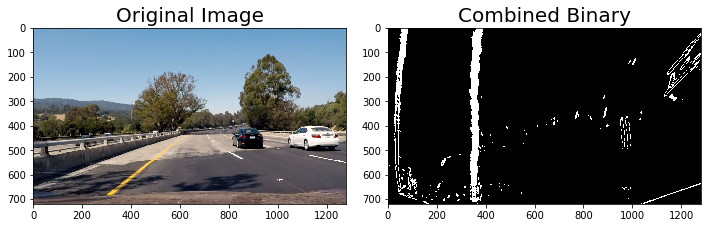

In [55]:
def binary_warp(img):
    
    undistort = calibration.undistort(img)
    warp = transform.warp(undistort)
    
    lab = cv2.cvtColor(warp, cv2.COLOR_BGR2LAB)
    a_channel = lab[:,:,1]

    # Sobel x y
    gray = cv2.cvtColor(warp, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=21) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 30 #45
    thresh_max = 80 #100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    a_thresh_min = 55 #95 
    a_thresh_max = 120  #115
    a_binary = np.zeros_like(a_channel)
    a_binary[(a_channel >= a_thresh_min) & (a_channel <= a_thresh_max)] = 1

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(a_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

for image in glob.glob('test_images/test4.jpg'):
    img = mpimg.imread(image)
    result = binary_warp(img)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    f.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(result, cmap='gray')
    ax2.set_title('Combined Binary', fontsize=20)
    plt.savefig('output_images/combined.jpg', bbox_inches='tight')

In [64]:
class lanefinder(object):
    
    def __init__(self):
        self.plot = False
    
    def should_plot(self, plot = False):
        self.frames_processed = 0
        self.plot = plot
        
    def apply_on_video(self, input_video = "project_video.mp4", output_video = "project_video_output.mp4", plot = False):
        self.plot = plot
        self.frames_processed = 0
        self.left_fit = None
        self.right_fit = None
        self.out_img = None
        
        # Import everything needed to edit/save/watch video clips
        from moviepy.editor import VideoFileClip
        from IPython.display import HTML

        set_prev = 0
        do_diagnosis = 1

        clip4 = VideoFileClip(input_video);
        white_clip = clip4.fl_image(self.apply_pipeline) #NOTE: this function expects color images!!
        %time white_clip.write_videofile(output_video, audio=False);
        
        HTML("""
        <video width="960" height="540" controls>
          <source src="{0}">
        </video>

        """.format(output_video))
        
    def apply_pipeline(self,img):
        global left_fit
        global right_fit
        global out_img
        global rad
        
        if(self.plot):
            f, ((ax11, ax12),(ax21, ax22)) = plt.subplots(2, 2, figsize=(12, 7))
            ax11.imshow(img)
            ax11.set_title('Original Image', fontsize=20)
        
        if(self.plot):
            ax12.imshow(binary_warp(img), cmap='gray')
            ax12.set_title('Binary Image', fontsize = 20)

        if(self.frames_processed == 0):
            binary_warped = binary_warp(img)
            # Find Lines
            # Assuming you have created a warped binary image called "binary_warped"
            # Take a histogram of the bottom half of the image
            histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
            # Create an output image to draw on and  visualize the result
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]/2)
            leftx_base = np.argmax(histogram[100:midpoint]) + 100
            rightx_base = np.argmax(histogram[midpoint:-100]) + midpoint

            # Choose the number of sliding windows
            nwindows = 30
            # Set height of windows
            window_height = np.int(binary_warped.shape[0]/nwindows)
            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base
            # Set the width of the windows +/- margin
            margin = 60
            # Set minimum number of pixels found to recenter window
            minpix = 20
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                binary_warped = binary_warp(img)
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
          
            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)

            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        else:
            binary_warped = binary_warp(img)
            # Assume you now have a new warped binary image 
            # from the next frame of video (also called "binary_warped")
            # It's now much easier to find line pixels!
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            margin = 60
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

            # Again, extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            
            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        if(self.plot):
            ax21.imshow(out_img)
            ax21.plot(left_fitx, ploty, color='yellow')
            ax21.plot(right_fitx, ploty, color='yellow')
            ax21.set_title('Polynomials', fontsize = 20)
            cv2.imwrite("output_images/line_fit_image.jpg", out_img)

        # Draw on Image
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = transform.unwarp(color_warp)
        
        undist = calibration.undistort(img)
        # Combine the result with the original image
        result_img = cv2.addWeighted(undist, 1, newwarp, 0.25, 0)
        
        y_eval = 719 # 720p video/image, so last (lowest on screen) y index is 719
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720.0 # meters per pixel in y dimension
        xm_per_pix = 3.7/700.0 # meters per pixel in x dimension
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
         # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters

        rad = np.mean([left_curverad, right_curverad])
        
        bottom_y = undist.shape[0] - 1
        bottom_x_left = left_fit[0]*(bottom_y**2) + left_fit[1]*bottom_y + left_fit[2]
        bottom_x_right = right_fit[0]*(bottom_y**2) + right_fit[1]*bottom_y + right_fit[2]
        vehicle_offset = undist.shape[1]/2 - (bottom_x_left + bottom_x_right)/2

        # Convert pixel offset to meters
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        vehicle_offset *= xm_per_pix
        
        curvature = 'Average curvature: %.2f m' % rad 
        lane_dist = 'Center offset: %.2f m' % -vehicle_offset
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        result = cv2.putText(result_img,curvature,(100, 90), font, 1.4, (255,255,255),2,cv2.LINE_AA)
        result = cv2.putText(result_img,lane_dist,(100, 150), font, 1.4, (255,255,255),2,cv2.LINE_AA)
        
        self.frames_processed = self.frames_processed + 1
        
        if(self.plot):
            ax22.imshow(result)
            ax22.set_title('Processed Image', fontsize = 20)
            plt.savefig('output_images/result.jpg', bbox_inches='tight')
        return result

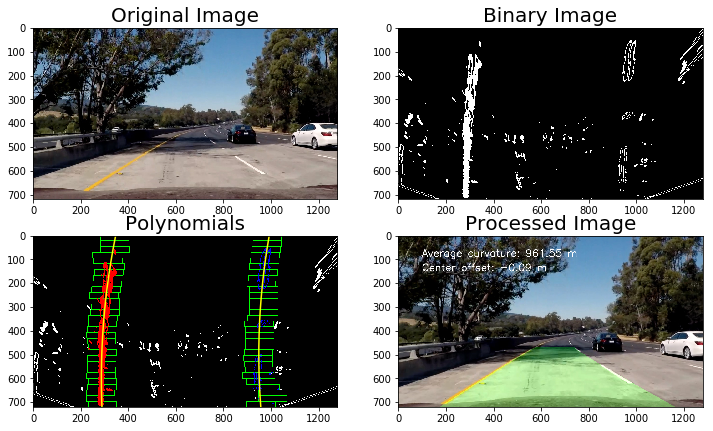

In [66]:
image = 'test_images/test5.jpg'
img = mpimg.imread(image)
LF = lanefinder()
LF.should_plot(True)
result = LF.apply_pipeline(img)

In [67]:
LF.apply_on_video(input_video='project_video.mp4', output_video='project_video_out.mp4')

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:42<00:00,  7.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 2min 43s


In [12]:
from IPython.display import HTML
project_output = 'project_video_output.mp4'

HTML("""
<video width="960" height="540" controls>
<source src="{0}">
</video>

""".format("project_video_out.mp4"))

In [13]:
#LF.apply_on_video(input_video='challenge_video.mp4', output_video='challenge_video_out.mp4')

In [14]:
project_output = 'challenge_video_output.mp4'

HTML("""
<video width="960" height="540" controls>
<source src="{0}">
</video>

""".format("challenge_video_out.mp4"))

In [15]:
#LF.apply_on_video(input_video='harder_challenge_video.mp4', output_video='harder_challenge_video_out.mp4')

In [16]:
project_output = 'harder_challenge_video_output.mp4'

HTML("""
<video width="960" height="540" controls>
<source src="{0}">
</video>

""".format("harder_challenge_video_out.mp4"))